In [1]:
from scipy.sparse import coo_matrix
from scipy.sparse import save_npz, load_npz
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from scipy import spatial
import pickle
import time

<br>Import original 'distance' matrix: *mx* as symmetirc matrix. 

Import page categories.

In [2]:
mx = load_npz('C:\\FOLDERS\\CEU\\Capstone Project\\Data\\sparse_matrix.npz')

In [3]:
mx_array = mx.toarray()

In [4]:
g = open("page_categories.pkl", "rb")
temp = pickle.load(g)
g.close()

In [5]:
categories = []

for key in temp:
    categories.append(temp[key])

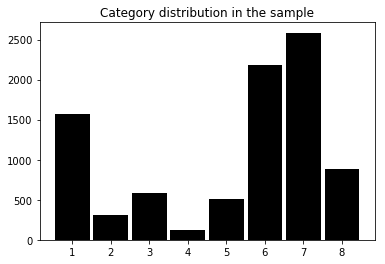

In [6]:
temp = np.array(categories)
bins = [1,2,3,4,5,6,7,8, 9]
plt.hist(temp, align = 'left', bins= bins, rwidth = 0.9, color = "k")
plt.title("Category distribution in the sample")
plt.show()

<br>
## Transform matrix elements
Replacing number of shared users with mx[i,j] = square(mx[i,j]) / (max(mx[i,:]) x max(mx[:,j])) creating a new kind of *dissimilarity matrix*.

In [7]:
mx_cos = np.zeros((8743, 8743)) # initializing the new dissimilarity matrix

In [8]:
t1 = time.time()
for i in range(0,8742):
    for j in range(i+1, 8743):
        mx_cos[i,j] = 100 * spatial.distance.cosine(mx_array[i,:], mx_array[:,j])
t2 = time.time()
print(t2 - t1)

4961.978316783905


In [9]:
np.savetxt("C:\\FOLDERS\\CEU\\Capstone Project\\Data\\mx_cosine_dissimilarity.gz", mx_cos, delimiter=',')

<br>
## Scipy Hierarchy Clustering

Getting upper triangular values.

In [10]:
l = [] # list for upper triangular (ex-diagonal) values

for i in range(0, 8742):
    for j in range(i + 1, 8743):
        l.append(mx_cos[i,j])

<br>
### Running clusters:
- linkage method: **'ward'**.

In [11]:
Z = linkage(l, method="ward")

- crosstabs

In [12]:
k=8
scipy_hier_labels = fcluster(Z, k, criterion='maxclust')
page_labels = pd.DataFrame(scipy_hier_labels, columns=["labels"])
cat = pd.Series(categories)
page_labels['category'] = cat.values
ct = pd.crosstab(page_labels["labels"], page_labels["category"])
ct

category,1,2,3,4,5,6,7,8
labels,,,,,,,,
1,63,8,0,1,33,81,149,41
2,202,16,9,2,72,130,566,9
3,47,11,11,2,73,183,338,32
4,39,8,1,8,20,67,71,50
5,376,154,238,62,251,909,1014,67
6,699,17,35,14,12,394,288,644
7,137,78,20,25,34,258,109,34
8,3,19,265,11,15,159,50,9


- plotting clusters vs original labels

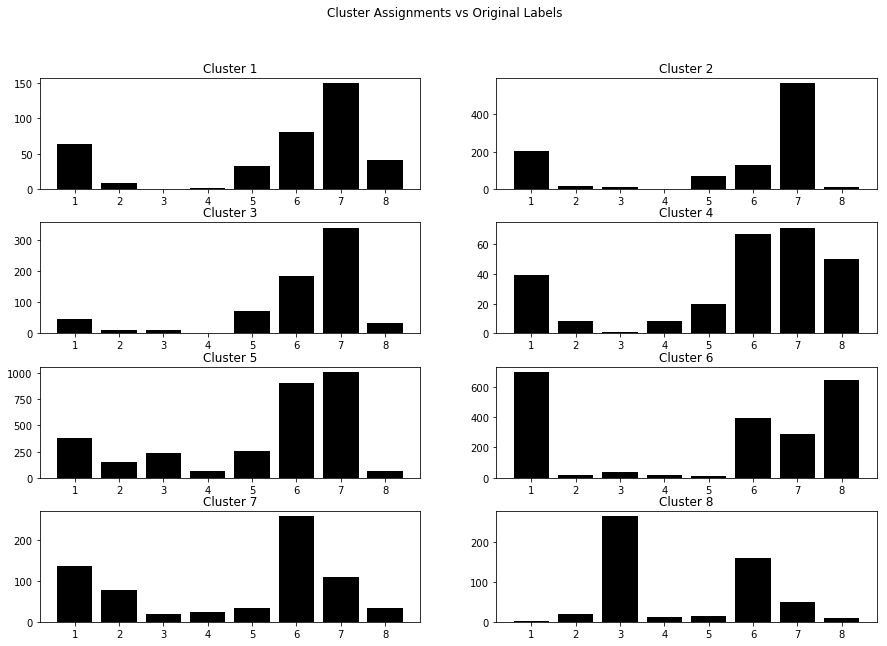

In [13]:
clusters = []

for i in range(0,8):
    clusters.append(ct.iloc[i].tolist())

fig, axes = plt.subplots(4, 2, figsize = (15,10))
fig.subplots_adjust(hspace = .3, wspace=.2)
fig.suptitle("Cluster Assignments vs Original Labels")
axes = axes.ravel()
for i in range(8):
    axes[i].bar([1,2,3,4,5,6,7,8], clusters[i], color = 'k')
    axes[i].set_title("Cluster " + str(i+1))
    axes[i].set_xticks([1,2,3,4,5,6,7,8])

----------------------------------------------------

As labeling in the clustering algorithm is random, we need to find the most frequent original category label within each cluster, as it should show which original category the cluster represent.

In [14]:
ctt = ct.T
lbls = list(range(1,9)) # labels given by the clustering method
c = []                  # the most frequent original category within that label
f = []                  # the frequency on that category within that particular cluster

for i in range(1,9):
    m = max(ctt[i])
    pdind = pd.Index(ctt[i])
    freq = m / sum(ctt[i])
    c.append(pdind.get_loc(m) + 1)
    f.append(round(freq,3))

assignment = pd.DataFrame({"cluster label": lbls,
                          "most frequent original category within the cluster": c,
                          "its relative frequency": f})
assignment = assignment[["cluster label", 
                         "most frequent original category within the cluster",
                        "its relative frequency"]]
assignment

,cluster label,most frequent original category within the cluster,its relative frequency
0,1,7,0.396
1,2,7,0.563
2,3,7,0.485
3,4,7,0.269
4,5,7,0.330
5,6,1,0.332
6,7,6,0.371
7,8,3,0.499


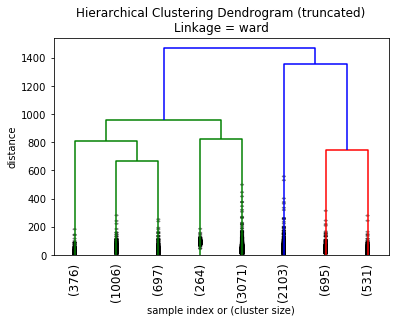

In [15]:
plt.title('Hierarchical Clustering Dendrogram (truncated)\nLinkage = ward')
plt.xlabel('sample index or (cluster size)')
plt.ylabel('distance')
dendrogram(
    Z,
    truncate_mode='lastp',  # show only the last p merged clusters
    p=8,  # show only the last p merged clusters
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True,  # to get a distribution impression in truncated branches
)
plt.show()

<br>
### Running clusters:
- linkage method: **'complete'**.

In [23]:
Z = linkage(l, method="complete")

- crosstabs

In [24]:
k=8
scipy_hier_labels = fcluster(Z, k, criterion='maxclust')
page_labels = pd.DataFrame(scipy_hier_labels, columns=["labels"])
cat = pd.Series(categories)
page_labels['category'] = cat.values
ct = pd.crosstab(page_labels["labels"], page_labels["category"])
ct

category,1,2,3,4,5,6,7,8
labels,,,,,,,,
1,371,94,101,25,113,631,839,208
2,162,18,40,20,48,200,175,124
3,231,26,84,9,65,210,265,89
4,174,42,105,20,58,200,255,95
5,123,47,66,7,54,138,205,53
6,162,33,68,24,66,270,302,132
7,94,23,34,9,48,214,263,50
8,249,28,81,11,58,318,281,135


- plotting clusters vs original labels

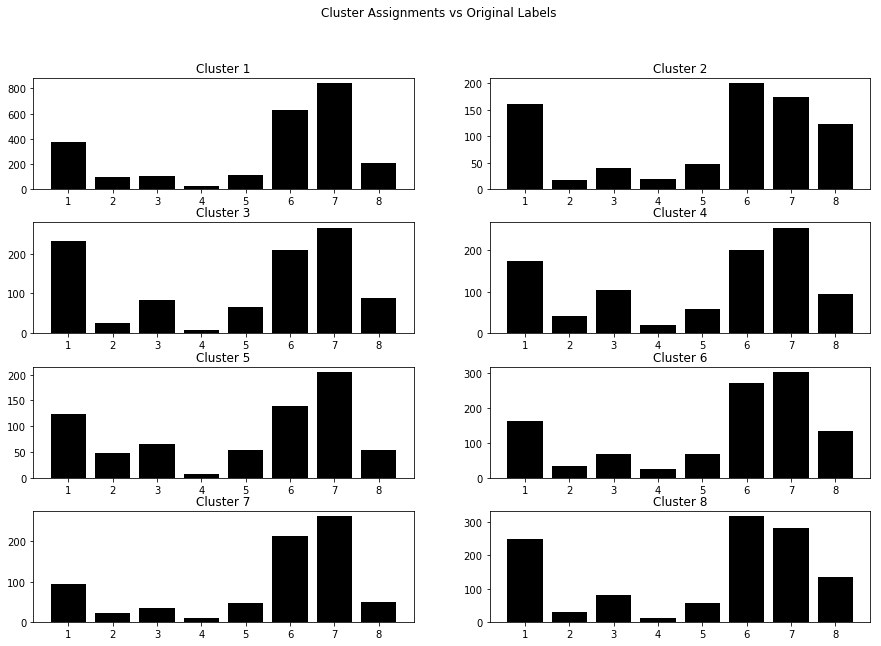

In [25]:
clusters = []

for i in range(0,8):
    clusters.append(ct.iloc[i].tolist())

fig, axes = plt.subplots(4, 2, figsize = (15,10))
fig.subplots_adjust(hspace = .3, wspace=.2)
fig.suptitle("Cluster Assignments vs Original Labels")
axes = axes.ravel()
for i in range(8):
    axes[i].bar([1,2,3,4,5,6,7,8], clusters[i], color = 'k')
    axes[i].set_title("Cluster " + str(i+1))
    axes[i].set_xticks([1,2,3,4,5,6,7,8])

----------------------------------------------------

As labeling in the clustering algorithm is random, we need to find the most frequent original category label within each cluster, as it should show which original category the cluster represent.

In [26]:
ctt = ct.T
lbls = list(range(1,9)) # labels given by the clustering method
c = []                  # the most frequent original category within that label
f = []                  # the frequency on that category within that particular cluster

for i in range(1,9):
    m = max(ctt[i])
    pdind = pd.Index(ctt[i])
    freq = m / sum(ctt[i])
    c.append(pdind.get_loc(m) + 1)
    f.append(round(freq,3))

assignment = pd.DataFrame({"cluster label": lbls,
                          "most frequent original category within the cluster": c,
                          "its relative frequency": f})
assignment = assignment[["cluster label", 
                         "most frequent original category within the cluster",
                        "its relative frequency"]]
assignment

,cluster label,most frequent original category within the cluster,its relative frequency
0,1,7,0.352
1,2,6,0.254
2,3,7,0.271
3,4,7,0.269
4,5,7,0.296
5,6,7,0.286
6,7,7,0.358
7,8,6,0.274


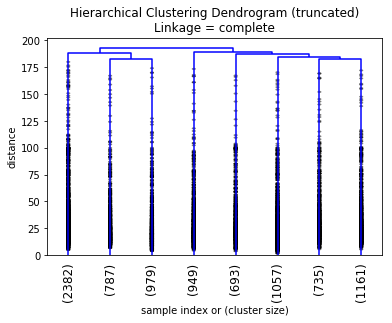

In [28]:
plt.title('Hierarchical Clustering Dendrogram (truncated)\nLinkage = complete')
plt.xlabel('sample index or (cluster size)')
plt.ylabel('distance')
dendrogram(
    Z,
    truncate_mode='lastp',  # show only the last p merged clusters
    p=8,  # show only the last p merged clusters
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True,  # to get a distribution impression in truncated branches
)
plt.show()